# A Demo of IML-ViT

This notebook provides a example of our training & inference pipeline of how to apply IML-ViT to image manipulation localization tasks.

### Requirements
You should install the requirements in `./requirements.txt` and manually install following requirements before run this note book：
- PyTorch
- OpenCV (cv2)

### Load Dataset
- We defined two types of Dataset class
  - `json_dataset`, which get input image and correspoding groundtruth from a json file with protocol like this:
    ```
    [
        [
          "/Dataset/CASIAv1/Tp/image1.jpg",
          "/Dataset/CASIAv2/Gt/image1.jpg"
        ],
        [
          "/Dataset/CASIAv1/Tp/image2.jpg",
          "Negative"
        ],
        ......
    ]
    ```
    where "Negative" represent a totally black groundtruth that don't needs a path(all authentic)
  - `mani_dataset` which loads image and groundtruth pairs automaticlly from a directory having sub-directories named as `Tp` (for input images) and `Gt` |(for groundtruths). This class will use sorted `os.listdir()` function to generate the pairs. 
- These datasets will do **zero-padding** automatically. Common augumentation method like ImageNet normalization will also be added.
- Both datasets can generate `edge_mask` when specify the `edge_width` parameter. Then, this dataset will return 3 objects (image, GT, edge mask) while only 2 objects when `edge_width=None`.
- For inference, returing the actual shape of the original image is crucial. You can set `if_return_shape=True` to get this value. 

In [2]:
# Pre-import and set for a clear ploting
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 60
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (24, 6)
from utils.datasets import mani_dataset # special Dataset class

In [4]:
# here we use mani dataset as example
input_dir = "./images/sample_iml_dataset/"
dataset = mani_dataset(
    path = input_dir,
    edge_width=7, # specify the edge mask, other wise only return 2 objects
    if_return_shape=True
)
print(dataset)
print(f":length of this dataset: {len(dataset)}")

:length of this dataset: 2


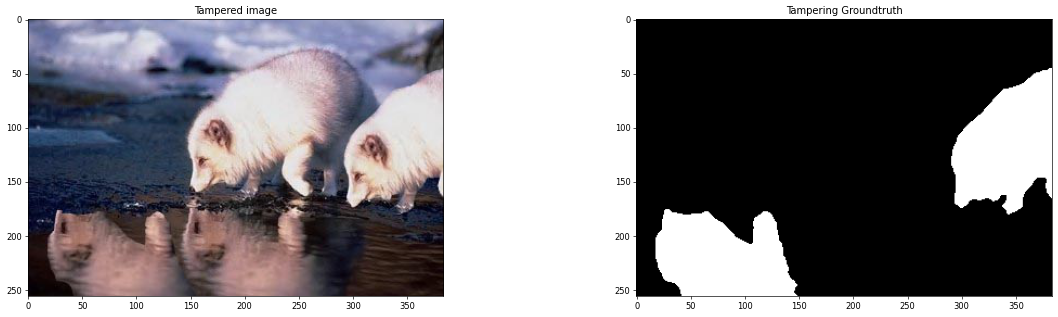

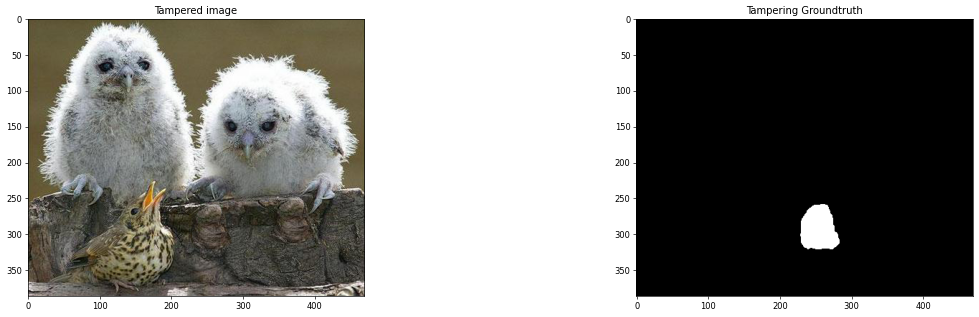

In [5]:
# Visualize datas without any augmentation
for img, gt in zip(dataset.tp_path, dataset.gt_path):
    img = plt.imread(img)
    gt = plt.imread(gt)
    plt.subplot(1, 2, 1)
    plt.title("Tampered image")
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.title("Tampering Groundtruth")
    plt.imshow(gt, cmap="gray")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


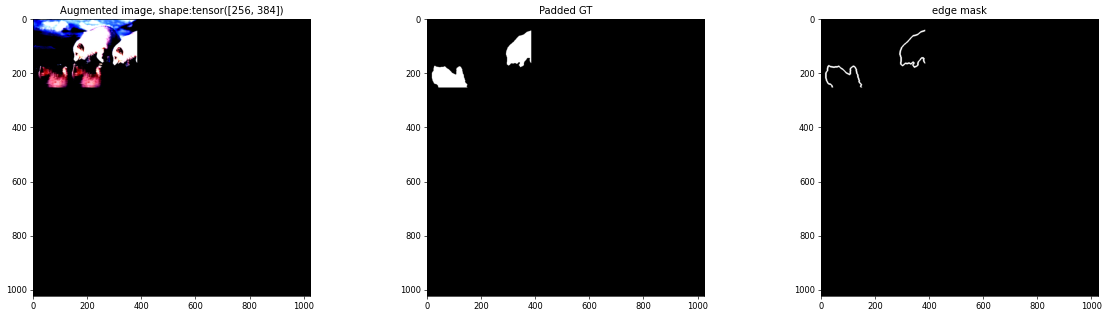

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


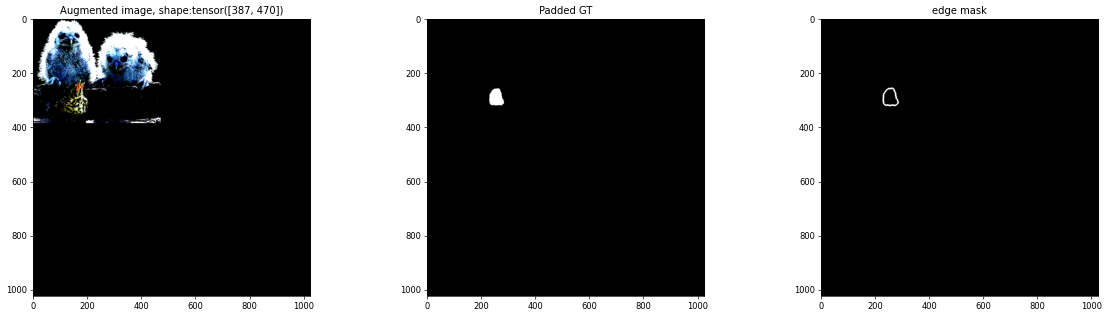

In [7]:
# Visualize after build-in transform (zero-padding and augmentations)
for img, gt, edge_mask, shape in dataset:
    plt.subplot(1, 3, 1)
    img = img.permute(1, 2, 0) # CHW -> HWC
    plt.imshow(img)
    plt.title(f"Augmented image, shape:{shape}")
    plt.subplot(1, 3, 2)
    gt = gt.permute(1, 2, 0) # CHW -> HWC
    plt.imshow(gt, cmap='gray')
    plt.title("Padded GT")
    plt.subplot(1, 3, 3)
    edge_mask = edge_mask.permute(1, 2, 0) # CHW -> HWC
    plt.imshow(edge_mask, cmap='gray')
    plt.title("edge mask")
    plt.show()

### Download the weights and init the IML-ViT model
You should download the pretrained weights from [Google Drive](https://drive.google.com/file/d/1xXJGJPW1i5j9Pc1JKd7fJmIAQkvt9jY7/view?usp=sharing) or [Baidu NetDisk](https://pan.baidu.com/s/1V-l1C6jCLBQTobrJcXDl7g?pwd=s835) and place it as `./checkpoints/iml-vit_checkpoint.pth`

In [8]:
import torch
from iml_vit_model import iml_vit_model

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # if out of memory, then uncommenting this line

print("Device:", device)

ckpt_path = "./checkpoints/iml-vit_checkpoint.pth"
model = iml_vit_model()

model.load_state_dict(
    torch.load(ckpt_path),
    strict = False
)
model = model.to(device)

/home/zewei/miniconda3/envs/pt2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


### Inference
This process require your GPU has at least 6GB of memory.

shape: tensor([256, 384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict Loss:0.022907032357723275, including edge loss: 0.020670106254297993


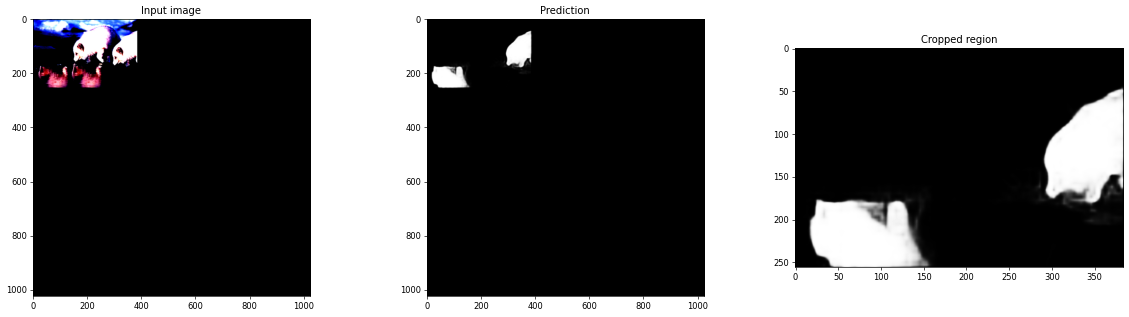

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape: tensor([387, 470])
Predict Loss:0.009990848471249732, including edge loss: 0.008573608372266506


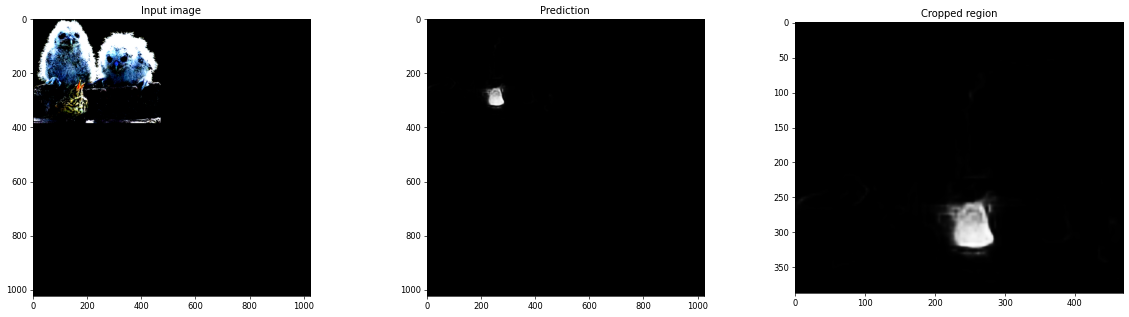

Done!


In [9]:
results = []
model.eval()
with torch.no_grad():
    for img, gt, edge_mask, shape in dataset:    # Inference don't need edge mask.
        img, gt, edge_mask = img.to(device), gt.to(device), edge_mask.to(device)
        # Since no Dataloader, manually create a Batch with size==1
        img = img.unsqueeze(0) # CHW -> 1CHW
        gt = gt.unsqueeze(0)
        edge_mask = edge_mask.unsqueeze(0)
        print("shape:", shape)
        # inference
        predict_loss, mask_pred, edge_loss = model(img, gt, edge_mask)
        print(f"Predict Loss:{predict_loss}, including edge loss: {edge_loss}")
        output = mask_pred
        
        # visualize
        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
        plt.subplot(1, 3, 2)
        plt.title("Prediction")
        plt.imshow(output.cpu().numpy()[0][0], cmap='gray')


        # Cut the origin area from padded image
        output = output[0, :, 0:shape[0], 0:shape[1]].permute(1, 2, 0).cpu().numpy()
        results.append(output)
        plt.subplot(1, 3, 3)
        plt.title("Cropped region")
        plt.imshow(output, cmap='gray')
        plt.show()
print("Done!")

### Thresholding & comparison

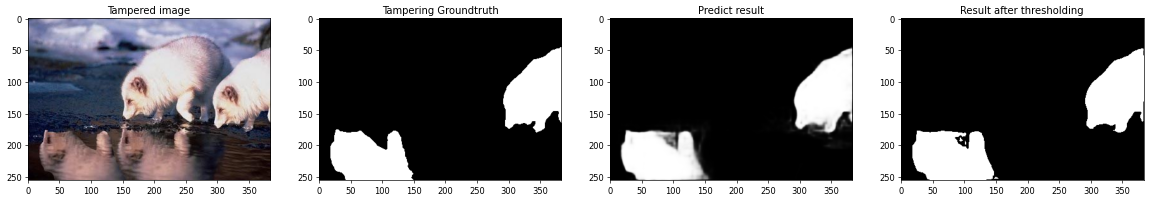

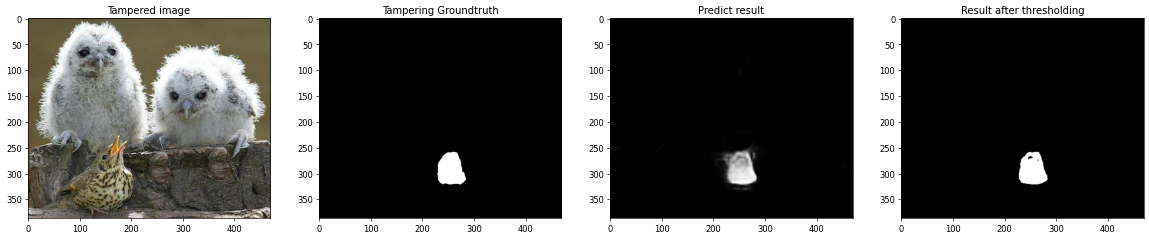

In [10]:
# Visualize the results:
for img, gt, res in zip(dataset.tp_path, dataset.gt_path, results):
    img = plt.imread(img)
    gt = plt.imread(gt)
    plt.subplot(1, 4, 1)
    plt.title("Tampered image")
    plt.imshow(img)
    plt.subplot(1, 4, 2)
    plt.title("Tampering Groundtruth")
    plt.imshow(gt, cmap="gray")
    plt.subplot(1, 4, 3)
    plt.title("Predict result")
    plt.imshow(res, cmap="gray")
    plt.subplot(1, 4, 4)
    plt.title("Result after thresholding")
    plt.imshow(res > 0.5, cmap="gray")
    plt.show()